# 全连接卷积神经网络（FCN）


FCN
- FCN是用深度神经网络来做语义分割的**奠基性**工作
- 用**转置卷积层**来替换CNN最后的全连接层，从而可以实现每个像素的预测
  - 先使用卷积神经网络抽取图像特征
  - 然后通过$1\times1$卷积层将通道数变换为类别个数
  - 最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸

## 代码

In [ ]:
!pip install d2l

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 构造模型

**使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征**


- **`.children()`**是pytorch中的一个方法，用于返回模型中**各个子模块的迭代器**
  - 返回的是一个**生成器对象**

In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 36.2MB/s]


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

**创建一个全卷积网络`net`**

In [ ]:
net = nn.Sequential(*pretrained_net.children())[:-2]

X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

**使用$1\times1$卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）  
并且需要将特征图的高宽增加32倍**，变回输入图像的高宽
- 输入高（宽）为$n$，核$k$，填充$p$，步幅$s$，则转置卷积$n'=sn+k-2p-s$

设置$1\times1$卷积层直接将通道数减少到21，主要是为了使得速度更快

In [ ]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(
  num_classes, num_classes, kernel_size=64, padding=16, stride=32
))

### 初始化转置卷积层

在图像处理中，有时需要上采样，**双线性插值**是常用的上采样方法之一，也**常用于初始化转置卷积层**
- 假设给定输入图像，计算上采样输出图像上的每个像素
  -  将输出图像的坐标$(x,y)$映射到输入图像的坐标$(x',y')$上
    - 例如，根据输入与输出的尺寸之比来映射
    - 注意，映射后的$x′$和$y′$是实数
  - 在输入图像上找到离坐标$(x',y')$最近的4个像素
  - 输出图像在坐标$(x,y)$上的像素依据输入图像上这4个像素及其与$(x',y')$的相对距离来计算
- 双线性插值的上采样可以通过转置卷积层实现，内核由以下`bilinear_kernel`函数构造
- **双线性插值卷积核的生成**
  - 对于大小为$k \times k $的卷积核，其权重值$w[i, j]$定义为：$$w[i, j] = \left( 1 - \frac{|i - c|}{r} \right) \cdot \left( 1 - \frac{|j - c|}{r} \right)$$
    - $i, j$的中心点坐标
    - $r $ 是中心点到边界的最大距离（即 $ r = \frac{k}{2}$）
    - $|i - c| $和$|j - c|$表示当前点到中心点的水平和垂直距离
  - 这个公式生成的卷积核是对称的，权重值随距离的增大逐渐减小
  - 捕获了双线性插值的加权特性

- `og`是一个二维坐标网格，将其用于广播操作可以生成一个`(kernel_size, kernel_size)`的矩阵，表示网格中每个元素的坐标
- `weight[range(in_channels), range(out_channels), :, :]`**还是有疑问？？？**

In [ ]:
# 双线性插值卷积核
def bilinear_kernel(in_channels, out_channels, kernel_size):
  factor = (kernel_size + 1) // 2  # 向下取整
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor - 0.5
  og = (
      torch.arange(kernel_size).reshape(-1, 1),
      torch.arange(kernel_size).reshape(1, -1)
  )
  filt = (1 - torch.abs(og[0] - center) / factor) * \
      (1 - torch.abs(og[1] - center) / factor)
  weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
  weight[range(in_channels), range(out_channels), :, :] = filt
  return weight

**用双线性插值的上采样实验**
- 由转置卷积层实现
- 构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用`bilinear_kernel`函数初始化

In [ ]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

读取图像`X`，将上采样的结果记为`Y`
- 为了打印图像，需要调整通道维的位置

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- `torchvision.transforms.ToTensor()`将图像数据转换为pytorch的tensor格式并进行归一化
  - `ToTensor()`是一个**类**
- 每次调用`imshow`都会覆盖之前画的图

In [15]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('/content/drive/My Drive/Colab Notebooks/img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

转置卷积层将图像的高宽分别放大了2倍，除了坐标刻度一样，打印出的与原图没什么两样

input image shape: torch.Size([561, 728, 3])
output image shaoe: torch.Size([1122, 1456, 3])


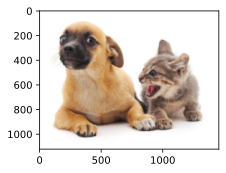

In [ ]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0))
print('output image shaoe:', out_img.shape)
d2l.plt.imshow(out_img)

**用双线性插值的上采样初始化转置卷积层**  
**对于$1\times1$卷积层，使用Xavier初始化参数**

In [ ]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);  # 前面定义了层的名称

### 读取数据集

In [ ]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


read 1078 examples


### 训练

使用转置卷积层的通道来预测像素的类别，需要在损失计算中指定通道维
- 正确率不是很高85%左右，说明边缘做的不是很好

In [ ]:
print(type(devices))

<class 'torch.device'>


In [ ]:
def loss(inputs, targets):
  return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd = 5, 0.001, 1e-3
devices = d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 预测

需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式
- `torchvision.models`中的预训练模型一般要求输入图像按ImageNet数据集的统计值进行标准化

In [ ]:
def predict(img):
  X = test_iter.dataset.normalize_image(img).unsqueeze(0)
  pred = net(X.to(devices[0])).argmax(dim=1)  # 在通道维度上取最大
  return pred.reshape(pred.shape[1], pred.shape[2])  # 图片的高宽

**可视化预测的类别**

In [ ]:
def label2image(pred):
  colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
  X = pred.long()
  return colormap[X, :]

In [ ]:
voc_dir = '/content/drive/My Drive/ColabData/data/VOCdevkit/VOC2012'
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []

- `torchvision.transforms.functional.crop(img, top, left, height, width)`
  - 与`functional.CenterCrop`和`RandomCrop`的区别：这个是手动指定裁剪位置和大小

In [ ]:
for i in range(n):
  crop_rect = (0, 0, 320, 480)
  X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
  pred = label2image(predict(X))
  imgs += [X.permute(1, 2, 0), pred.cpu(),torchvision.transforms.functional.crop(
    test_labels[i], *crop_rect).permute(1, 2, 0)
  ]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2)

边缘预测的比较模糊

**注**
- 如果用多层小kernel的转置卷积，慢慢上采样，效果会更好（这里是直接一层到位）

## 练习

1. 如果将转置卷积层改用Xavier随机初始化，结果会有什么变化？

In [1]:
!pip install d2l

In [13]:
import torch
import torchvision

from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [7]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
net = nn.Sequential(*pretrained_net.children())[:-2]  # 输出通道数512，高宽减少32倍
# net = nn.Sequential(*list(pretrained_net.children())[:-2])

num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(
  num_classes, num_classes, kernel_size=64, padding=16, stride=32
))

In [8]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 21, 320, 480])

In [12]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor -0.5
  # 形成了包含形状(kernel_size, 1)和(1, kernel_size)这两个tensor
  og = (torch.arange(kernel_size).reshape(-1, 1), torch.arange(kernel_size).reshape(1, -1))
  # 进行广播，得到(kernel_size, kernel_size)形状的tensor
  # 表示每个位置的双线性插值的权重
  filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
  weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
  # 卷积核的权重张量，对每对输入输出通道共享一个`filt`权重矩阵
  weight[range(in_channels), range(out_channels), :, :] = filt
  return weight

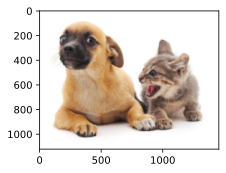

In [16]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)

conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))  # 初始化
img = torchvision.transforms.ToTensor()(d2l.Image.open('/content/drive/My Drive/Colab Notebooks/img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)  # 上采样
out_img = Y[0].detach().permute(1, 2, 0)  # 前后都无所谓

d2l.set_figsize()
d2l.plt.imshow(img.permute(1, 2, 0))
d2l.plt.imshow(out_img)

In [21]:
def train_bacth_ch13(net, X, y, loss, trainer, devices):
  if isinstance(X, list):
    X = [x.to(devices) for x in X]
  else:
    X = X.to(deivces)
  y = y.to(deivces)
  net.train()
  trainer.zero_grad()
  l = loss(net(X), y)
  l.sum().backward()
  trainer.step()
  train_loss_sum = l.sum()
  train_acc_sum = d2l.accuracy(pred, y)
  return train_loss_sum, train_acc_sum


def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_gpu(i=1)):
  timer = d2l.Timer()
  num_batches = len(train_iter)
  net = nn.DataParallel(net, device_id=devices)
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = train_batch_ch13(
        net, features, labels, loss, trainer, devices
      )
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(
          epoch + (i + 1) / num_batches,
          (metric[0] / metric[2], metric[1] / metric[3], None)
        )
    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  print(f'loss {metric[0] / metric[2]:.3f}, train acc '
    f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
    f'{str(devices)}')

**loss为什么这样定义**  
**`d2l.train_ch13`再回顾一遍，是怎么写的？？**

- 交叉熵损失计算：输入需要提供每个像素的*所有类别的预测概率*（logits）
- `d2l.try_gup()`得到的是`device(type='cpu')`，无法`devices[0]`
  -  TypeError: 'torch.device' object is not subscriptable

In [ ]:
def loss(inputs, targets):
  # 对于逐像素的损失，最终得到每个样本的平均损失
  return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)  # 对高和宽都做平均

nn.init.xavier_uniform_(net.transpose_conv.weight)
# net.transpose_conv.weight.data.copy_(W)

batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_gpu(i=1)
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

2. 预测测试图像中所有像素的类别

In [ ]:
def predict(img):
  X = test_iter.dataset.normalize_image(img).unsqueeze(0)
  pred = net(X.to(devices[0])).argmax(dim=1)
  return pred.reshape(pred.shape[1], pred.shape[2])